## Tutorial on how to use Parcels on NEMO curvilinear grids

Parcels also supports [curvilinear grids](https://www.nemo-ocean.eu/doc/node108.html) such as those used in the [NEMO models](https://www.nemo-ocean.eu/).

We will be using the example data in the `NemoCurvilinear_data/` directory. These fiels are a purely zonal flow on an aqua-planet (so zonal-velocity is 1 m/s and meridional-velocity is 0 m/s everywhere, and no land). However, because of the curvilinear grid, the `U` and `V` fields vary north of 26N.

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, ParticleFile, plotTrajectoriesFile
from parcels import AdvectionRK4
import numpy as np
from datetime import timedelta as delta

We can create a `FieldSet` just like we do for normal grids. Note that we need to provide an extra filename for the `mesh_mask` file that holds information on the Curvilinear grid.

In [2]:
filenames = {'U': 'NemoCurvilinear_data/U_purely_zonal-ORCA025_grid_U.nc4',
             'V': 'NemoCurvilinear_data/V_purely_zonal-ORCA025_grid_V.nc4',
             'mesh_mask': 'NemoCurvilinear_data/mesh_mask.nc4'}
variables = {'U': 'U',
             'V': 'V'}
dimensions = {'U': {'lon': 'nav_lon_u', 'lat': 'nav_lat_u'},
              'V': {'lon': 'nav_lon_v', 'lat': 'nav_lat_v'}}
field_set = FieldSet.from_nemo(filenames, variables, dimensions, mesh='spherical', allow_time_extrapolation=True)

INFO: Generating rotation angles fields in file: NemoCurvilinear_data_rotation_angles.nc


Note that the `FieldSet.from_nemo()` function assumes some default values for the `mesh_mask` file. If your `mesh_mask` file has different variables and dimensions, you can set these with a dictionary such as the default one below, and add that as `dimensions=dimensions` to the call of `FieldSet.from_nemo()`.

In [3]:
variables['mesh_mask'] = {'cosU': 'cosU',
                          'sinU': 'sinU',
                          'cosV': 'cosV',
                          'sinV': 'sinV'}
dimensions['mesh_mask'] = {'U': {'lon': 'glamu', 'lat': 'gphiu'},
                           'V': {'lon': 'glamv', 'lat': 'gphiv'},
                           'F': {'lon': 'glamf', 'lat': 'gphif'}}

And we can plot the `U` field. Note that we need to rescale the `grid.lon` so that it is monotonic (needed for plotting purposes only; Parcels itself can handle non-monotonic grids)

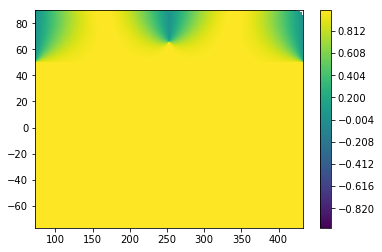

In [4]:
# Remap the longitudes because field.show() requires monotonic longitudes
field_set.U.grid.lon[field_set.U.grid.lon<73] += 360
field_set.U.show()

# Now reverse the remapping above
field_set.U.grid.lon[field_set.U.grid.lon > (72+360)] -=360

As you see above, the `U` field indeed is 1 m/s south of 50N, but varies with longitude and latitude north of that

Now we can run particles as normal. Parcels will take care to rotate the `U` and `V` fields

In [5]:
# Start 20 particles on a meridional line at 180W
npart = 20
lonp = -180 * np.ones(npart)
latp = [i for i in np.linspace(-70, 88, npart)]

# Create a periodic boundary condition kernel
def periodicBC(particle, pieldSet, time, dt):
    if particle.lon > 180:
        particle.lon -= 360

pset = ParticleSet.from_list(field_set, JITParticle, lon=lonp, lat=latp)
pfile = ParticleFile("nemo_particles", pset)
kernels = pset.Kernel(AdvectionRK4) + periodicBC
pset.execute(kernels, runtime=delta(days=50), dt=delta(hours=6),
             interval=delta(days=1), output_file=pfile)

INFO: Compiled JITParticleAdvectionRK4periodicBC ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gr/T/parcels-504/ae256881993532bad8b3758037987412.so


And then we can plot these trajectories. As expected, all trajectories go exactly zonal and due to the curvature of the earth, ones at higher latitude move more degrees eastward (even though the distance in km is equal for all particles)

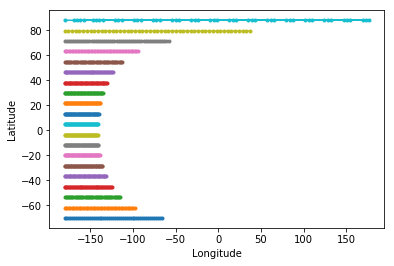

In [6]:
plotTrajectoriesFile("nemo_particles.nc")